# DCGAN
- 생성자와 판별자를 합성곱 신경망으로 표현
- 배치정규화: 공변량 변화를 감소시키는 방법, 입력을 다음 층으로 전달하기 전에 각 층의 출력을 정규화

## 모듈 임포트

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## 모델의 입력 차원

In [2]:
img_rows = 28
img_cols = 28
channels = 1

#입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자의 입력으로 사용할 잡음 벡터의 크기
z_dim = 100

## 생성자
- 전치 합성곱 사용: 깊이를 줄이는 동안 너비와 높이를 증가

In [3]:
def build_generator(z_dim):    # 랜덤 잡음 벡터 받기

    model = Sequential()

    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Activation('tanh'))

    return model

## 판별자
- 이미지를 받아 예측 벡터를 출력하는 합성곱 신경망과 비슷한 ConvNet
- 이진분류기: 입력이미지가 가짜인지 진짜 인지 나타냄

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## 모델 생성과 컴파일

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model


# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [6]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        ##  판별자 훈련

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        
        ##  생성자 훈련

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

## 생성된 이미지 출력

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## 모델 실행

1000 [D 손실: 0.386723, 정확도: 85.55%] [G 손실: 1.955741]


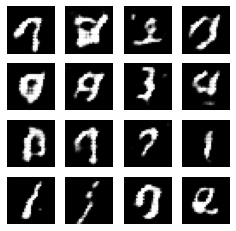

2000 [D 손실: 0.400792, 정확도: 81.64%] [G 손실: 1.782477]


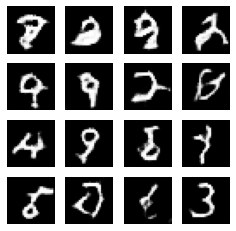

3000 [D 손실: 0.458734, 정확도: 78.91%] [G 손실: 1.964425]


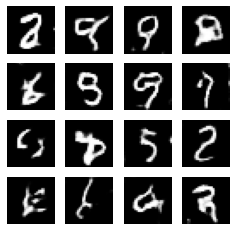

4000 [D 손실: 0.377968, 정확도: 87.89%] [G 손실: 1.975426]


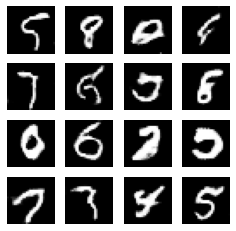

5000 [D 손실: 0.357434, 정확도: 83.20%] [G 손실: 2.423370]


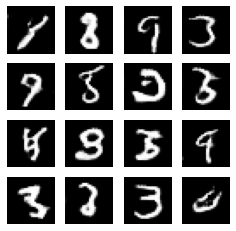

6000 [D 손실: 0.351128, 정확도: 86.72%] [G 손실: 2.215759]


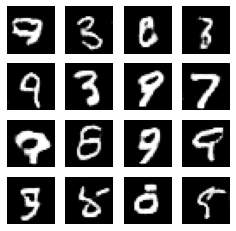

7000 [D 손실: 0.399338, 정확도: 82.81%] [G 손실: 1.846168]


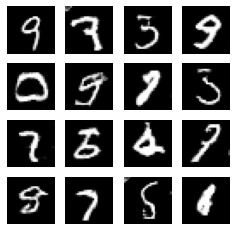

8000 [D 손실: 0.394626, 정확도: 82.42%] [G 손실: 1.858314]


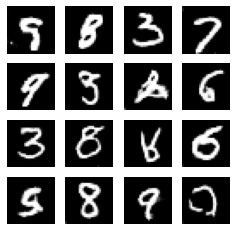

9000 [D 손실: 0.365574, 정확도: 86.72%] [G 손실: 2.346858]


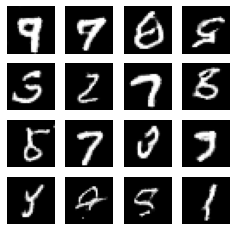

10000 [D 손실: 0.403130, 정확도: 83.20%] [G 손실: 2.666041]


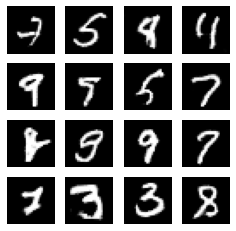

11000 [D 손실: 0.336727, 정확도: 85.16%] [G 손실: 2.354845]


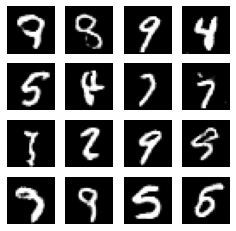

12000 [D 손실: 0.282714, 정확도: 90.62%] [G 손실: 2.139799]


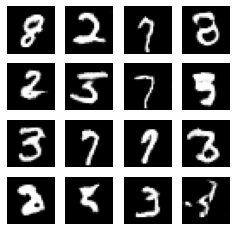

13000 [D 손실: 0.413059, 정확도: 78.52%] [G 손실: 2.109735]


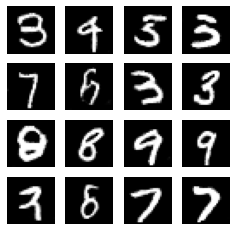

14000 [D 손실: 0.358059, 정확도: 84.77%] [G 손실: 2.214070]


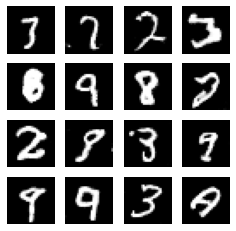

15000 [D 손실: 0.430870, 정확도: 81.25%] [G 손실: 1.689004]


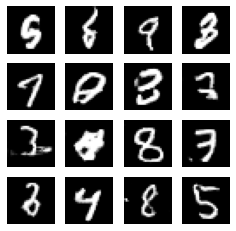

16000 [D 손실: 0.404862, 정확도: 80.47%] [G 손실: 2.121807]


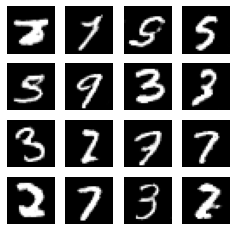

17000 [D 손실: 0.386700, 정확도: 82.03%] [G 손실: 2.079749]


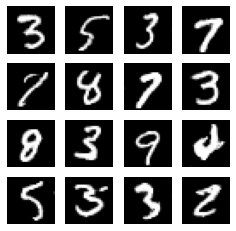

18000 [D 손실: 0.351504, 정확도: 84.38%] [G 손실: 2.063943]


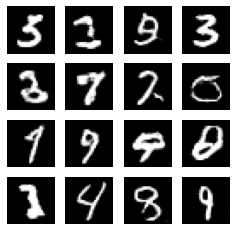

19000 [D 손실: 0.373615, 정확도: 82.42%] [G 손실: 2.478889]


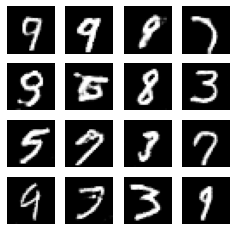

20000 [D 손실: 0.301255, 정확도: 86.33%] [G 손실: 2.391788]


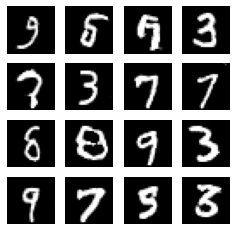

In [8]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)